<a href="https://colab.research.google.com/github/anshupandey/Reinforcement-Learning/blob/main/Code_RL_Stock_Trading_using_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install yfinance
!pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=731110b66ffc28960d18a4a09aaa7a2522676d20b694bceb32511c25994f6025
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from yahoofinancials import YahooFinancials
from collections import deque
import random
from pandas_datareader import data as pdr

In [4]:

sns.set()
!pip install yfinance --upgrade --no-cache-dir

import fix_yahoo_finance as yf

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

     |████████████████████████████████| 63 kB 10.4 MB/s 
     |████████████████████████████████| 6.4 MB 16.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [14]:
df = yf.download('AAPL', 
                      start='2019-01-01', 
                      end='2021-06-12', 
                      progress=False,
)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.277523,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.464802,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.936085,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.856087,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.539616,164101200


In [16]:
df_full= df.copy()
name = 'Q-learning agent'

In [17]:
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [18]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.


epoch: 10, total rewards: 101.315044.3, cost: 0.194867, total money: 10101.315044
epoch: 20, total rewards: 75.955048.3, cost: 0.162672, total money: 10075.955048
epoch: 30, total rewards: 59.975033.3, cost: 0.153156, total money: 10059.975033
epoch: 40, total rewards: 94.975044.3, cost: 0.123253, total money: 10094.975044
epoch: 50, total rewards: 53.100056.3, cost: 0.118271, total money: 10053.100056
epoch: 60, total rewards: 70.360043.3, cost: 0.099887, total money: 10070.360043
epoch: 70, total rewards: 47.387554.3, cost: 0.089539, total money: 10047.387554
epoch: 80, total rewards: 79.577560.3, cost: 0.076260, total money: 10079.577560
epoch: 90, total rewards: 101.205048.3, cost: 0.070640, total money: 10101.205048
epoch: 100, total rewards: 84.222553.3, cost: 0.064722, total money: 10084.222553
epoch: 110, total rewards: 79.022552.3, cost: 0.059914, total money: 10079.022552
epoch: 120, total rewards: 55.677578.3, cost: 0.048948, total money: 10055.677578
epoch: 130, total rewar

In [19]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 39.480000, total balance 9960.520000
day 1, sell 1 unit at price 35.547501, investment -9.960737 %, total balance 9996.067501,
day 7: buy 1 unit at price 38.072498, total balance 9957.995003
day 8, sell 1 unit at price 37.500000, investment -1.503706 %, total balance 9995.495003,
day 16: buy 1 unit at price 39.439999, total balance 9956.055004
day 17: buy 1 unit at price 39.075001, total balance 9916.980003
day 18, sell 1 unit at price 38.669998, investment -1.952334 %, total balance 9955.650002,
day 23, sell 1 unit at price 43.544998, investment 11.439532 %, total balance 9999.195000,
day 25: buy 1 unit at price 42.735001, total balance 9956.459999
day 26, sell 1 unit at price 42.602501, investment -0.310050 %, total balance 9999.062500,
day 31: buy 1 unit at price 42.605000, total balance 9956.457500
day 32: buy 1 unit at price 42.732498, total balance 9913.725002
day 35, sell 1 unit at price 43.242500, investment 1.496305 %, total balance 9956.967503,
day 

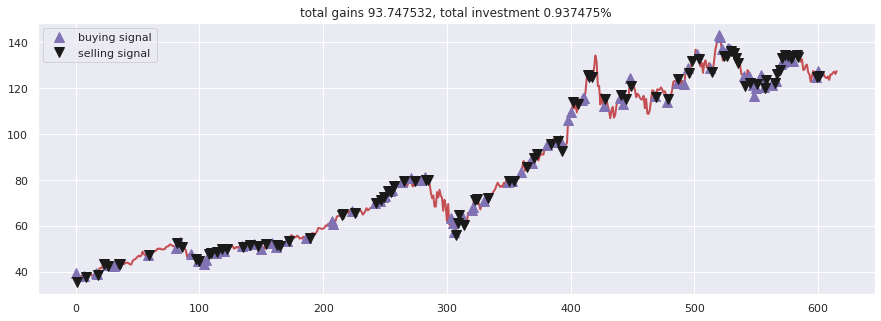

In [20]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()